# Flow Over Stationary Sphere

The simulation of a laminar flow over a stationary sphere is used for the validation of force spreading aspects of the immersed boundary method (IBM). For that purpose, the drag coefficient is measured through the forces calculated at the Lagrangian mesh.

In [1]:
from nassu.cfg.model import ConfigScheme

filename = "tests/validation/cases/07_flow_over_sphere.nassu.yaml"

sim_cfgs = ConfigScheme.sim_cfgs_from_file_dct(filename)

A multilevel configuration is adopted to allow a large ratio between the sphere's and domain's sizes.

In [2]:
sim_laminar = [sim_cfg for (name, _), sim_cfg in sim_cfgs.items() if name.startswith("laminar")]
sim_turb = next(
    sim_cfg for (name, _), sim_cfg in sim_cfgs.items() if name == "turbulentFlowOverSphere"
)
sim_turb_les = next(sim_cfg for (name, _), sim_cfg in sim_cfgs.items() if name.endswith("LES"))
sim_cfgs_use = sim_laminar + [sim_turb] + [sim_turb_les]

Functions to use for flow over sphere processing

In [3]:
import pandas as pd
import pathlib

from nassu.cfg.schemes.simul import SimulationConfigs


def get_experimental_profile_Cp(reynolds: float) -> pd.DataFrame:
    files_tau: dict[float, str] = {
        4200: "Flow_over_sphere/Re_4200/Cp_vs_theta.csv",
        50000: "Flow_over_sphere/Re_50000/Cp_vs_theta.csv",
        300000: "Flow_over_sphere/Re_300000/Cp_vs_theta.csv",
        400000: "Flow_over_sphere/Re_400000/Cp_vs_theta.csv",
        1140000: "Flow_over_sphere/Re_1140000/Cp_vs_theta.csv",
    }
    file_get = files_tau[reynolds]

    filename = pathlib.Path("tests/validation/comparison") / file_get

    # ([theta], [Cp])
    df = pd.read_csv(filename, delimiter=",")
    return df


def get_experimental_profile_Cd() -> pd.DataFrame:
    file_get = "Flow_over_sphere/drag_coefficient.csv"
    filename = pathlib.Path("tests/validation/comparison") / file_get
    # ([Author], [Re], [Cd])
    df = pd.read_csv(filename, delimiter=",")
    return df


u_reference = 0.00549


def get_height_scale(sim_cfg: SimulationConfigs, reynolds: float) -> float:
    global u_reference
    kin_visc = sim_cfg.models.LBM.kinematic_viscosity
    return u_reference / kin_visc

## Results

Good agreement with correlations found in literature is found for the drag coefficient, with better results achieved at higher Reynolds number. For such cases, the boundary proximity is expected to have smaller effect in the result of drag coefficient.

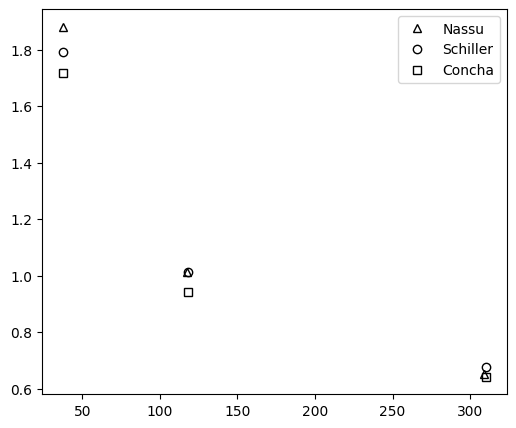

In [4]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
fig.set_size_inches(6, 5)

num_vals = {"x": [], "y": []}
for sim_cfg in sim_laminar:
    output_sphere = sim_cfg.output.bodies["sphere"]
    last_step = output_sphere.interval.get_all_process_steps(sim_cfg.n_steps)[-1]
    filename_nodes = output_sphere.nodes_data_csv(last_step)
    df_body = pd.read_csv(filename_nodes)
    diameter = df_body["pos_x"].max() - df_body["pos_x"].min()

    # Force in flow direction
    sum_F = df_body["force_x"].sum()
    # Average rho
    rho_inf = 1
    # Inlet velocity
    u_inf = max(bc.ux for bc in sim_cfg.models.BC.BC_map if "ux" in bc.model_dump())
    # Circunference area
    sphere_lvl = df_body["lvl"].max()
    area = np.pi * (diameter * 2**sphere_lvl) ** 2 / 4

    reynolds = u_inf * diameter / sim_cfg.models.LBM.kinematic_viscosity

    Cd = -sum_F / (0.5 * rho_inf * area * u_inf**2)

    num_vals["x"].append(reynolds)
    num_vals["y"].append(Cd)

ax.plot(num_vals["x"], num_vals["y"], "^k", fillstyle="none", label="Nassu")

df_exp = get_experimental_profile_Cd()
authors = ["Schiller", "Concha"]
styles = ["ok", "sk"]
for author, style in zip(authors, styles):
    ax.plot(df_exp["Re"], df_exp[author], style, fillstyle="none", label=author)

ax.legend()

plt.show(fig)

The pressure coefficient for the case of turbulent flow around a stationary sphere is performed for a Re=4,200 simulation to check capacity of measuring the pressure coefficient using the historic series function for a body. A posterior LES simulation is then performed for a Re=50,000 to also verify the solver stability for high Reynolds simulations. In both cases, excellent agreement with experimental data was obtained.

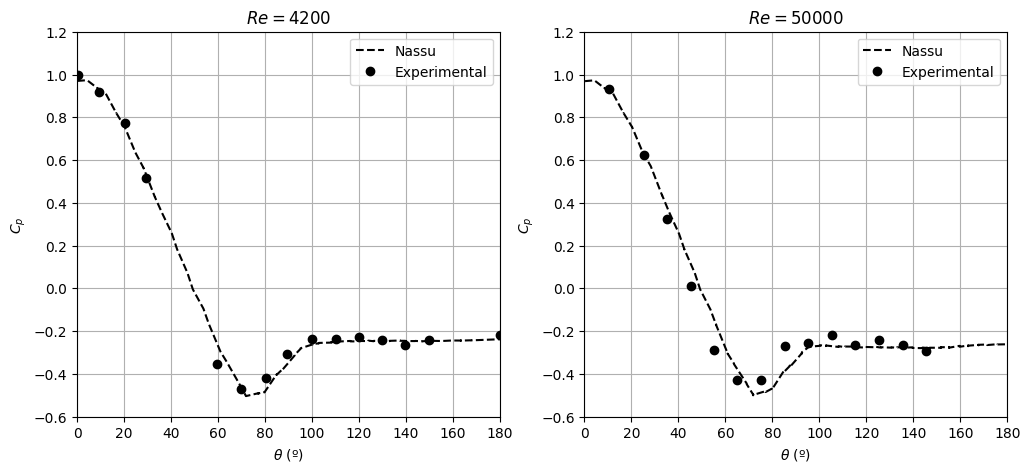

In [5]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 5)


def post_proc_crossflow_sphere_Cp(
    sim_cfg: SimulationConfigs, ax, reynolds: float, u_inf: float = 0.05
):
    hs = sim_cfg.output.series["default"].bodies["sphere"]

    df_points = pd.read_csv(hs.points_filename)
    df_hs = hs.read_full_data("rho")

    sphere_center = tuple(df_points[d].mean() for d in ("x", "y", "z"))

    # Use only points in z=0 to calculate Cp
    bool_arr = np.zeros((len(df_points),), dtype=np.bool_)
    df_points = df_points.loc[
        (df_points["z"] <= sphere_center[2] + 0.5) & (df_points["z"] >= sphere_center[2] - 0.5)
    ]
    bool_arr[df_points["idx"]] = True

    # TODO: This comes from sim_cfg, now hand written,
    # but update to calculate it automatically
    rho_inf = 1
    df_hs = df_hs[df_hs["time_step"] >= 10000]
    df_rho = df_hs.drop(columns="time_step")
    df_cp = (df_rho - rho_inf) / (1.5 * rho_inf * (u_inf**2))
    Cp_avg = df_cp.mean().to_numpy().T
    Cp_avg = Cp_avg[bool_arr]

    # Get angles for points, use acos because it goes from 0 to 180
    x = df_points["x"] - df_points.mean()["x"]
    y = df_points["y"] - df_points.mean()["y"]
    points_angles: np.ndarray = np.arccos(-x / (x**2 + y**2) ** 0.5)
    # Convert to angles
    points_angles *= 180 / np.pi
    points_angles = np.array(points_angles)

    # # Sort arrays
    argsort = points_angles.argsort()
    points_angles = points_angles[argsort]
    cp_points = Cp_avg[argsort]

    ax.plot(points_angles, cp_points, "--k", label="Nassu")

    df_exp = get_experimental_profile_Cp(reynolds)
    ax.plot(df_exp["theta"], df_exp["Cp"], "ok", label="Experimental")

    ax.legend()


for i, (sim_cfg, reynolds) in enumerate([(sim_turb, 4200), (sim_turb_les, 50000)]):
    post_proc_crossflow_sphere_Cp(sim_cfg, ax[i], reynolds, u_inf=0.05)
    ax[i].set_xlim((0, 180))
    ax[i].set_ylim((-0.6, 1.2))
    ax[i].set_ylabel("$C_p$")
    ax[i].set_xlabel(r"$\theta$ (º)")
    ax[i].grid()
    ax[i].set_title(f"$Re={reynolds}$")

plt.show(fig)

The pressure coefficient curve is very similar for both Re = 4200 and Re= 50,000. It can be seen better proximity of results in the LES simulation with a higher Reynolds number.

## Version

In [6]:
sim_info = sim_cfg.output.read_info()

nassu_commit = sim_info["commit"]
nassu_version = sim_info["version"]
print("Version:", nassu_version)
print("Commit hash:", nassu_commit)

Version: 1.6.17
Commit hash: 5df3ec0ad15e12b77724741bae33d94b7ff021d9


## Configuration

In [7]:
from IPython.display import Code

Code(filename=filename)

simulations:
  - name: laminarFlowOverSphere
    save_path: ./tests/validation/results/07_flow_over_sphere/laminar

    n_steps: 40000

    report: { frequency: 1000 }
    debug:
      profile: false
      output_only: false
      output_IBM_nodes: false
      multiblock:
        run_communication: true
        export_comm_vtk: false
        export_used_nodes: true

    domain:
      domain_size:
        x: 480
        y: 160
        z: 160
      block_size: 8
      bodies:
        sphere:
          lnas_path: fixture/lnas/basic/sphere.lnas
          transformation:
            scale: [1.6, 1.6, 1.6]
            translation: [112, 72, 72]
      refinement:
        static:
          default:
            volumes_refine:
              - start: [96, 64, 64]
                end: [160, 96, 96]
                lvl: 1
                is_abs: true

    data:
      divergence: { frequency: 10 }
      instantaneous:
        default: { interval: { frequency: 1000 }, macrs: [rho, u] }
      export_IBM_nodes:
        frequency: 5000

    models:
      precision:
        default: single

      LBM:
        tau: 0.51
        vel_set: D3Q27
        coll_oper: RRBGK
      initialization:
        rho: 1.0
        u:
          x: !unroll [0.007854, 0.024583, 0.064583]
          y: 0
          z: 0

      engine:
        name: CUDA

      BC:
        periodic_dims: [false, false, false]
        BC_map:
          - pos: N
            BC: Neumann
            wall_normal: N
            order: 0

          - pos: S
            BC: Neumann
            wall_normal: S
            order: 0

          - pos: F
            BC: Neumann
            wall_normal: F
            order: 1

          - pos: B
            BC: Neumann
            wall_normal: B
            order: 1

          - pos: E
            BC: RegularizedNeumannOutlet
            rho: 1.0
            wall_normal: E
            order: 2

          - pos: W
            BC: UniformFlow
            wall_normal: W
            rho: 1
            ux: !unroll [0.007854, 0.024583, 0.064583]
            uy: 0
            uz: 0
            order: 2

          - pos: NF
            BC: Neumann
            wall_normal: N
            order: 0

          - pos: NB
            BC: Neumann
            wall_normal: N
            order: 0

          - pos: SF
            BC: Neumann
            wall_normal: S
            order: 0

          - pos: SB
            BC: Neumann
            wall_normal: S
            order: 0

          - pos: NF
            BC: Neumann
            wall_normal: F
            order: 1

          - pos: NB
            BC: Neumann
            wall_normal: B
            order: 1

          - pos: SF
            BC: Neumann
            wall_normal: F
            order: 1

          - pos: SB
            BC: Neumann
            wall_normal: B
            order: 1

      IBM:
        forces_accomodate_time: 1000
        body_cfgs:
          default: {}

      multiblock:
        overlap_F2C: 2

  - name: turbulentFlowOverSphere
    parent: laminarFlowOverSphere

    save_path: ./tests/validation/results/07_flow_over_sphere/turbulent

    n_steps: 100000

    domain:
      domain_size:
        x: 640
        y: 128
        z: 128
      block_size: 8

      bodies: !not-inherit
        sphere:
          small_triangles: "add"
          lnas_path: fixture/lnas/basic/sphere.lnas
          transformation:
            scale: [0.8, 0.8, 0.8]
            translation: [112, 60, 60]

      refinement:
        static:
          default:
            volumes_refine:
              - start: [96, 32, 32]
                end: [224, 96, 96]
                lvl: 1
                is_abs: true
              - start: [104, 56, 56]
                end: [144, 72, 72]
                lvl: 3
                is_abs: true

    data:
      probes:
        historic_series:
          default:
            macrs: ["u", "rho"]
            interval: { frequency: 20, lvl: 0 }
            bodies:
              sphere:
       